# Heart rate estimation, signal de-noising and mobile health
The goal of this lab is to study an algorithm for correctly retrieving the timing instants of an ECG (EKG) time series. We will implement a simplified variant of the [Pan-Tompkins algorithm](https://ieeexplore.ieee.org/stamp/stamp.jsp?tp=&arnumber=4122029) and we will test it on real ECG data recordings. Towards the end of the lab you will be asked to apply your algorithms to the problem of heart rate estimation using a mobile device.

### Objectives
By the end of this session you should be able to understand the main challenges in the estimation of EGC signals. How to work from modeling assupmtions in order to exploit your prior knowledge in the estimation task.

* _Note: Everything below this line should be truned in as part of your lab report._

***

### Signal generation and template matching
In this task we will implement a simple version of a QRS-complex detector by using template matching, thresholding and non-maximum suppresion on the
observed ECG signal. We will then use those detections to provide an estimate of the heart rate.

* **Signal Generation -** We are going to create a synthetic EGC signal that we will be using to test our detector algorithm. For that purpose generate a stream of $10$ equally spaced pulses over a time span of $10\ s$ and with a sampling rate of $f_s = 256\ Hz$. The goal of this task is to create a basic model for a ECG signal. You can think of the signal as the convolution of a canonical pulse shape $\varphi(t)$ with a stream of Dirac delta functions: 

   $$x(t) = \sum_{k=1}^K a_k\, \varphi(t-t_k) = \varphi(t) \ast \sum_{k=1}^K a_k\, \delta(t-t_k),$$ 

   where $K$ is the number of pulses observed, $a_k$ represent the amplitudes of the different pulses and $t_k$ correspond to the locations of the pulses in time. For the purpose of this task use the canonical pulse shape generated by the `ecg_wave()` function defined in the notebook and constant unit amplitudes $a_k=1$. Make sure to scale your function in time so that its support is only $1/10\ s$. Plot the generated signal over time adding the appropriate labels for the axis.


In [0]:
# Josh Krachman Lab 1
# ============================================================================
# import modules
# ============================================================================
# Note that this part of the code needs to be run prior to any other code cell

import numpy as np
import json
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import signal

# inline plots
%matplotlib inline
sns.set()

# ============================================================================
# functions
# ============================================================================
def ecg_wave(x):
    """
    This function generates a synthetic ECG template of unit length (support).

    """
    
    # compute signal (superposition of splines)
    return 0.3 * signal.bspline(3*3*x-7.5,2)\
         + 0.15* signal.bspline(3*4*x-2,3)\
         + signal.bspline(3*2*2*x-6,1) - 0.2 * signal.bspline(3*4*x-5,1) - 0.4 * signal.bspline(3*4*x-7,1)



Text(0.5, 1.0, 'Single QRS-complex')

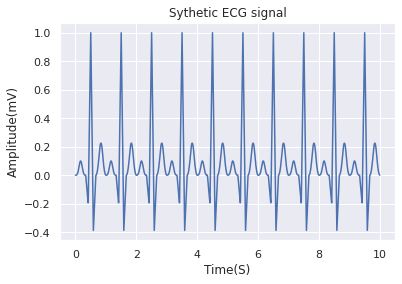

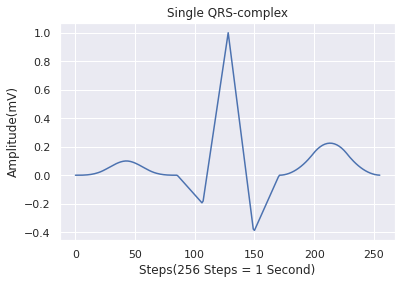

In [4]:
deltasignal = np.zeros(2561)

for i in range(10):
  deltasignal[i*256 +128] = 1
  
t = np.linspace(0, 10, 2561)

x = np.convolve(ecg_wave(t[0:256]), deltasignal, "same")


plt.plot(t,x) 
plt.xlabel('Time(S)')
plt.ylabel('Amplitude(mV)')
plt.title('Sythetic ECG signal')

plt.figure()
plt.plot(ecg_wave(t[0:256]))
plt.xlabel('Steps(256 Steps = 1 Second)')
plt.ylabel('Amplitude(mV)')
plt.title('Single QRS-complex')

* **Simulate Noise -** Generate a noisy version of the synthetic ECG signal generated before by adding Gaussian noise with standard deviation $\sigma=0.5$. Plot the noisy observations. Can you identify the locations of the QRS-complex?

Cannot identify locations of the QRS-complex


Text(0.5, 1.0, 'Single QRS-complex')

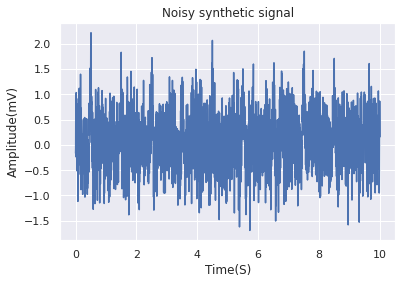

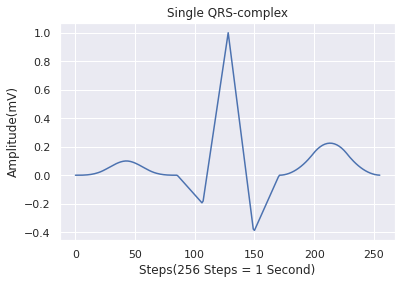

In [5]:
import numpy.random as rnd
n = 0.5 * rnd.randn(len(x))
noisy_signal = x + n
plt.plot(t, noisy_signal[0:2561])
plt.xlabel('Time(S)')
plt.ylabel('Amplitude(mV)')
plt.title('Noisy synthetic signal')

print('Cannot identify locations of the QRS-complex')

plt.figure()
plt.plot(ecg_wave(t[0:256]))
plt.xlabel('Steps(256 Steps = 1 Second)')
plt.ylabel('Amplitude(mV)')
plt.title('Single QRS-complex')

* **Find Peaks -** Implement a QRS-complex detector on the noisy signal you just generated. For that purpose we will use template matching, thresholding, and non-maximum suppression. We recommend that you normalize the signal before thresholding. For instance, you can normalize the signal to take values in the range $[0,1]$ or you could standardize the signal by making it zero mean and unit variance. After normalization define a threshold value and keep only those values of the signal that are above the given threshold. Once you have done that, perform a non-maximum suppression (i.e., keep a value if it is greater than the previous and following values). To implement the thresholding and non-maximum suppression operations you can use `signal.find_peaks` function.

In [6]:
def normalize_range(x):
    """
    Normalizes the signal such that its minimum value is 0 and its maximum value is 1,
    provided the signal is not identically zero.
    """
    # check that there are non-zero elements
    if np.any(x):
        
        # subtract minimum
        minx = np.min(x)
        z = x - minx
        
        # divide by max value
        maxz = np.max(z)
        return z/maxz
    
    else:
        
        return x
      
newx = x[0:256]
newwx = np.correlate(newx,noisy_signal, 'same')
signal_norm = normalize_range(newwx)

#plt.plot(signal_norm)
#plt.xlabel('Steps (256 Steps = 1 second)')
#plt.ylabel('Amplitude(V)')

peaks = signal.find_peaks(signal_norm, height=0.75)
print('Peak indices')
print(peaks[0])


Peak indices
[ 385  640  826  897 1151 1408 1662 1920 2177 2433]


* **RR Intervals -** Plot the original (synthetic) ECG signal as well as the locations of the peaks to verify your method. Keep in mind to compensate for any delay you might have introduced by filtering. From the peak binary signal, estimate the $RR$ interval sequence $r_n$ and its average value as:

$$ \bar R = \frac{1}{N}\sum_{n=0}^N r_n, $$

where $N$ is the number of peaks detected. Provide an estimate of the average heart beat rate in beats per minute $[bpm]$.


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  


Average heart beat rate is 52.5 bpm.


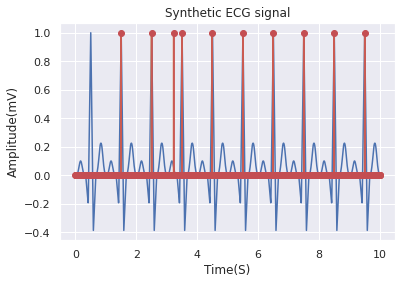

In [7]:


estimate_peaks = np.zeros(len(signal_norm))
estimate_peaks[peaks[0]] = 1

plt.plot(t, x)
plt.plot(t, estimate_peaks)
plt.stem(t, estimate_peaks, '-r', 'ro')
plt.xlabel('Time(S)')
plt.ylabel('Amplitude(mV)')
plt.title('Synthetic ECG signal')

rrarray = np.zeros(10)
rrarray = peaks[0]
rrarraydif = np.zeros(9)
    
for i in range(8):
  rrarraydif[i] = (rrarray[i+1]-rrarray[i])

rravg = (1/8) * sum(rrarraydif)
rravg = rravg/256*60

print('Average heart beat rate is {} bpm.'.format(rravg))


### QRS complex detection via Pan-Tompkins algorithm
Now let us consider a more realistic scenario where we have a noisy ECG signal where we don't know a priori the shape of the QRS-complex waeform. There are different
sources of noise that can be present during an ECG acquisition. In addition to high-frequency thermal
noise, it is also common to observe the presence of low-frequency interference coming from breathing. 
When it comes to pathologies, different non-additive distortions might be present on the ECG signal 
that alter the shape of the QRS-complex itself but for the purpose of this task we just assume a healthy 
individual where signal distortion comes solely from the acquisition process. The procedure that we
will employ in order to estimate the locations of the QRS-complex is based on the Pan-Tompkins
algorithm [Pan-Tompkins algorithm](https://ieeexplore.ieee.org/stamp/stamp.jsp?tp=&arnumber=4122029).

* **Effect of noise** - Load the signal **ecg_mitnst.json** and plot the signal over time. The signal corresponds to a sample ECG from the [MIT noise stress dataset](https://physionet.org/physiobank/database/nstdb/)
that has been downloaded from [physionet.org](https://physionet.org/physiobank/database/).
Plot the signal and observe the presence of a strong low-frequency component.

In [8]:
# access files stored on Google Drive from Colab
from google.colab import drive
drive.mount('gdrive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at gdrive/


[0.0, 0.002777777777777778, 0.005555555555555556, 0.008333333333333333, 0.011111111111111112, 0.013888888888888888, 0.016666666666666666, 0.019444444444444445, 0.022222222222222223, 0.025, 0.027777777777777776, 0.030555555555555555, 0.03333333333333333, 0.03611111111111111, 0.03888888888888889, 0.041666666666666664, 0.044444444444444446, 0.04722222222222222, 0.05, 0.05277777777777778, 0.05555555555555555, 0.058333333333333334, 0.06111111111111111, 0.06388888888888888, 0.06666666666666667, 0.06944444444444445, 0.07222222222222222, 0.075, 0.07777777777777778, 0.08055555555555556, 0.08333333333333333, 0.08611111111111111, 0.08888888888888889, 0.09166666666666666, 0.09444444444444444, 0.09722222222222222, 0.1, 0.10277777777777777, 0.10555555555555556, 0.10833333333333334, 0.1111111111111111, 0.11388888888888889, 0.11666666666666667, 0.11944444444444445, 0.12222222222222222, 0.125, 0.12777777777777777, 0.13055555555555556, 0.13333333333333333, 0.1361111111111111, 0.1388888888888889, 0.14166

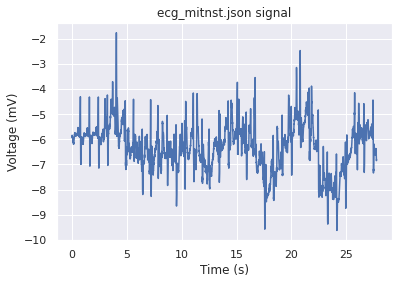

In [9]:
#a
# load data from Google Drive
with open('gdrive/My Drive/Data Science/Lab Course Labs/lab1/data_ecglab/ecg_mitnst.json','r') as infile:
    data = json.load(infile)

    # print data to see dictionary fields
    print(data['time'])

    plt.plot(data['time'],data['voltage'])
    plt.xlabel('Time (s)')
    plt.ylabel('Voltage (mV)')
    plt.title('ecg_mitnst.json signal')
    
    time = data['time']
    voltage = data['voltage']
    

* **Pan-Tompkins Algorithm -** In order to deal with noise we will implement a simplified version of the Pan-Tompkins algorithm. For that purpose proceed as follows:

  1. _Bandpass filtering:_ Follow the steps described in the manual in order to perform a bandpass filtering operation as the concatenation of lowpass and highpass filtering operations. Display the obtained signals at the intermediate steps.
  
  2. _Differentiation:_ Use the discrete filter $d_n$ to approximate the derivative of the underlying signal:
  
    $$ d_n = \frac{1}{8}\big(\delta_{n-2} + 2\delta_{n-1} -2\delta_{n+1} - \delta_{n+2}\big) $$
  
    The filter is intended to localize the steepest region in the QRS-complex.
  
  3. _Signal squaring:_ Square the obtained signal after differentiation and plot the obtained waveform. On the squared signal use an averaging filter of length $L=20$. Why was squaring helpful in revealing the peaks of the QRS complex?
  
  3. _Integration:_ Integrate the resulting signal from the squaring operation with a box window of length $L=50$. Display the resulting signal.
  
  4. _Peak detection:_ Use a peak detector to reveal the locations of the peaks. Estimate the average $RR$ interval and plot the sequence of estimated peaks.
 

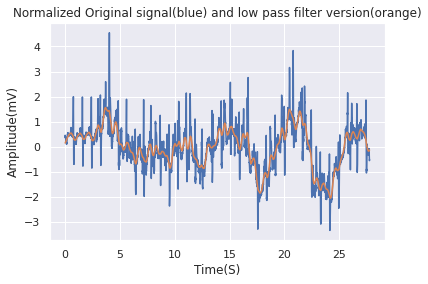

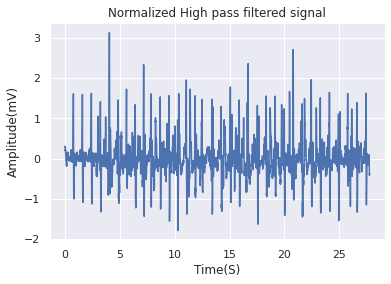

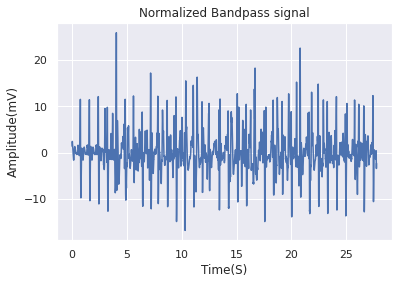

In [10]:

###1
#high pass

N = 100
xbox1 = np.zeros(N)
xbox2 = np.zeros(N)

v = voltage - np.mean(voltage)



# fill-in with ones the first 10 entries
xbox1[0:N] = 1
xbox2[0:N] = 1
triangle = np.convolve(xbox1,xbox2)
triangle = triangle/sum(triangle)
newvoltage = np.convolve(v,triangle,'same')

##prints high pass filter
plt.plot(time,v)
plt.plot(time, newvoltage)
plt.title('Normalized Original signal(blue) and low pass filter version(orange)')
plt.xlabel('Time(S)')
plt.ylabel('Amplitude(mV)')

plt.figure()
plt.plot(time,v-newvoltage)
plt.title('Normalized High pass filtered signal')
plt.xlabel('Time(S)')
plt.ylabel('Amplitude(mV)')


#low pas

NN = 10
xbox3 = np.zeros(NN)
xbox3[0:NN] = 1
lowpassvoltage = np.convolve(xbox3,v-newvoltage,'same')
##prints low pass
plt.figure()
plt.plot(time,lowpassvoltage)
plt.title('Normalized Bandpass signal')
plt.xlabel('Time(S)')
plt.ylabel('Amplitude(mV)')


deriv = [(1/8),(1/4),0,(-1/4),(-1/8)]






Text(0, 0.5, 'Amplitude(mV)')

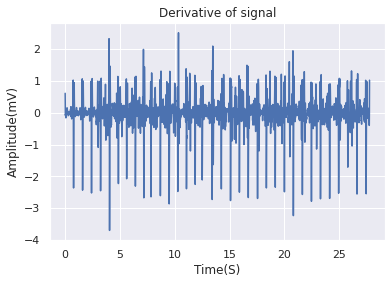

In [11]:
##2
deriv = [(1/8),(1/4),0,(-1/4),(-1/8)]
stuff = np.convolve(deriv,lowpassvoltage,'same')
plt.plot(time,stuff)
plt.title('Derivative of signal')
plt.xlabel('Time(S)')
plt.ylabel('Amplitude(mV)')

Text(0.5, 1.0, 'Derivative Squared of Signal')

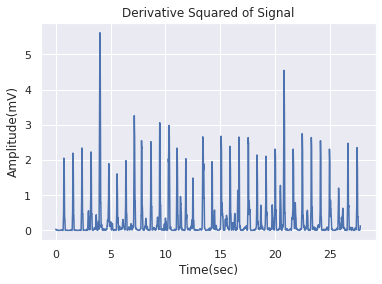

In [12]:
#3
import numpy as np
squared_deriv = np.power(stuff,2)

def moving_avgfilter(arr, n = 3):
  a = np.cumsum(arr, dtype=float)
  a[n:] = a[n:] - a[:-n]
  return a[n-1:]/n


avgsqrderiv = moving_avgfilter(squared_deriv, 20)
new_time = moving_avgfilter(time,20)
plt.plot(new_time,avgsqrderiv)



plt.xlabel('Time(sec)')
plt.ylabel('Amplitude(mV)')
plt.title('Derivative Squared of Signal')


##squaring was helpful becuse it raises the negative voltages to the positive 
##side while also showing the extremes both in the negative and positive directions.
##This makes it easier to compare the locations of the extremes in the original signal

Text(0, 0.5, 'Amplitude(mV)')

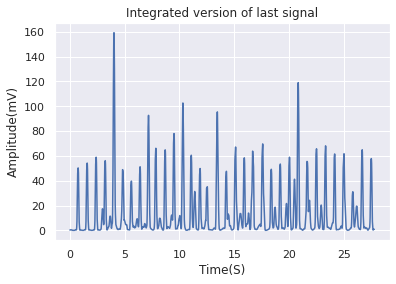

In [13]:
##4
##integrate with box window of length 50
box = np.ones(50)

integ = np.convolve(box,avgsqrderiv,'same')
plt.plot(new_time,integ)
plt.title('Integrated version of last signal')
plt.xlabel('Time(S)')
plt.ylabel('Amplitude(mV)')

Average rr interval is is 64.36607142857143 bpm.


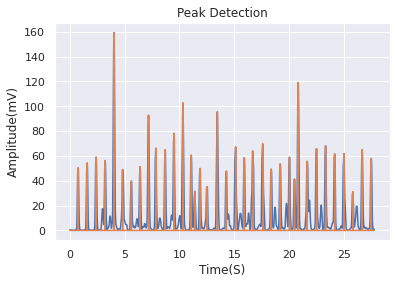

In [14]:
##5
newpeaks = signal.find_peaks(integ, height = 31, distance = 50)
newpeaks[0]

estpk = np.zeros(len(integ))
estpk[newpeaks[0]] = integ[newpeaks[0]]

plt.plot(new_time,integ)
plt.plot(new_time,estpk)
plt.title('Peak Detection')
plt.xlabel('Time(S)')
plt.ylabel('Amplitude(mV)')

values = newpeaks[0]

extremes = np.zeros(len(values)-1)  
for i in range(len(values)-1):
  extremes[i] = (values[i+1]-values[i])
  extremes[i] = (extremes[i]/256) * 60

averagerr = (1/(len(extremes))) * (sum(extremes))
averagerr
print('Average rr interval is is {} bpm.'.format(averagerr))


### Mobile health
In this last task we will consider the estimation of the heart rate in a less controlled scenario. In this case,
the signal comes from a mobile device and it is not a one-dimensional time-series but a video recording. Those with a
smartphone can record and use their own signals for the experiment. Alternatively, you can use the video
provided for that purpose. The recorded signal consists of a video of the tip of the finger placed
right in front of the camera while the camera flash is on. Play this video on your notebook and try to observe
the intensity variations due to the heart beat.

* Using the video signal and the methods studied in previous sections estimate the average heart rate from it.



In [15]:
import io
import base64
from IPython.display import HTML

# this code displays the video
video = io.open('gdrive/My Drive/Data Science/Lab Course Labs/lab1/data_ecglab/ppg_resized.mp4', 'r+b').read()
encoded = base64.b64encode(video)
HTML(data='''<video alt="test" controls>
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii')))

Text(0, 0.5, 'Voltage(mV)')

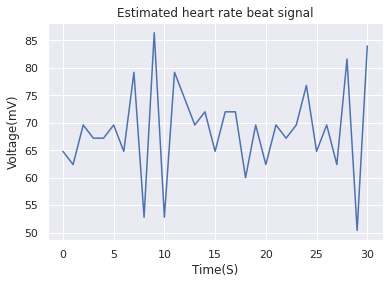

In [16]:
import cv2

# create video reader object
vread = cv2.VideoCapture("gdrive/My Drive/Data Science/Lab Course Labs/lab1/data_ecglab/ppg_resized.mp4")

# get number of frames
nframes = int(vread.get(cv2.CAP_PROP_FRAME_COUNT))

# get frame rate
fps = vread.get(cv2.CAP_PROP_FPS)


arrmeans = [ ]
# loop over frames
for ff in range(nframes):
    # read frames
    ret, img = vread.read()
    arrmeans.append(np.mean(img))
    
demeaned =  arrmeans - np.mean(arrmeans)



peaks3 = signal.find_peaks(demeaned,height = 0.5, distance = 20)


###indexes
peaks3[0]


##plt.plot(demeaned)

rsequence = np.diff(peaks3[0])
rmean = np.mean(rsequence)

bpm = (rmean/fps) * 60

bpm

val =  rsequence/fps * 60


plt.figure()
plt.plot(val)
plt.title('Estimated heart rate beat signal')
plt.xlabel('Time(S)')
plt.ylabel('Voltage(mV)')

In [17]:
####find mean rr, divide by period to convert to beats per second, multiply by 60 to get bpm

finalval = np.mean(img)
print('Estimate heart rate is {} bpm.'.format(finalval))

Estimate heart rate is 79.81144714355469 bpm.
